# 프로젝트 요약
1. 프로젝트 : Data Labeling
2. 프로젝트 : Feature Engineering
3. 프로젝트 : Model Traning

# 1. 프로젝트 : Data Labeling

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

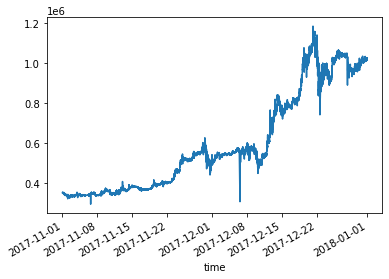

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

## ① Price Change Direction 적용하기
- 먼저 window를 설정합니다. 보통 window는 시계열 데이터에서 이전 시점과 현재 시점간의 간격을 구간별로 잘라서 사용하곤 합니다.
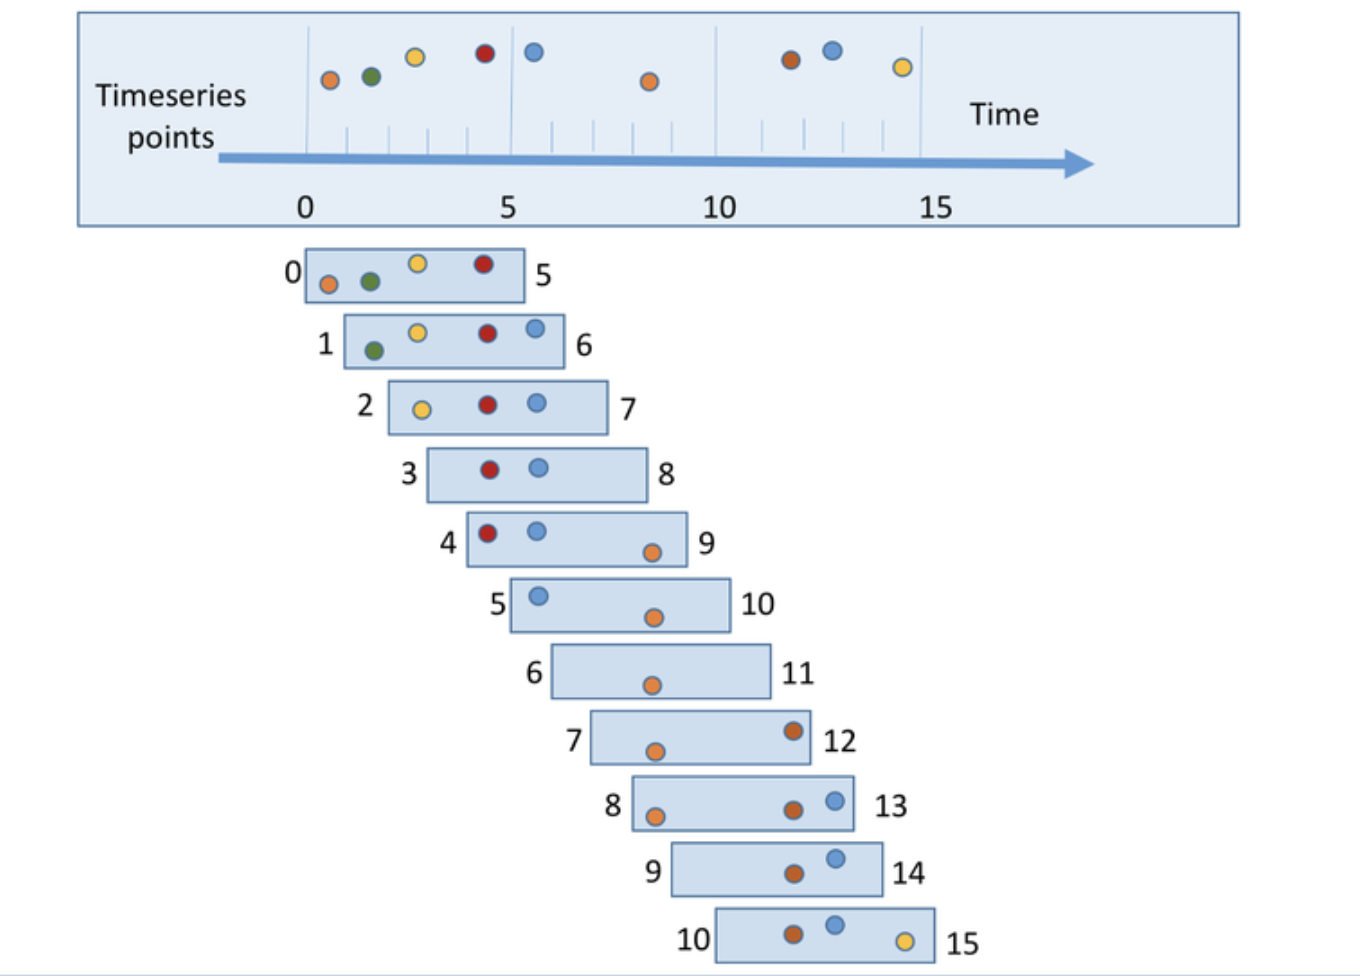

In [3]:
# Q. 코드를 작성해주세요

# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기 (shift: 함수를 주어진 양만큼 뒤로 이동시킨다. 1이면 전날의 종가를 현재로 가져옴.)
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)  # 데이터 활용을 위해 pd.Series를 사용합니다.

* np.sign() 함수는 주어진 값의 부호를 반환. 양수면 1, 음수면 0을 반환한다.

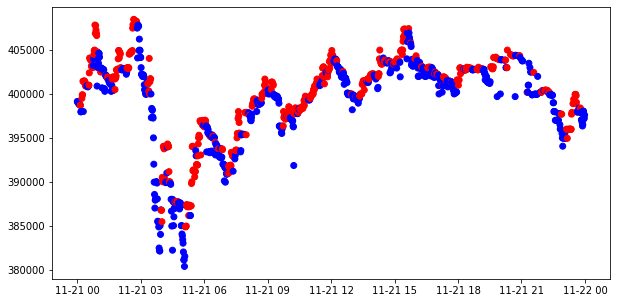

In [5]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

* 11/21일의 시간대별 모멘텀 신호가 시각화되었다. 
* np.where(조건, 참일때 값, 거짓일때 값) : 1일 때 (양일때) 빨간 값으로 표현

## ② Using Moving Average 적용하기
- 이동평균

In [6]:
# Q. 코드를 작성해주세요

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # pd.Series로 변환

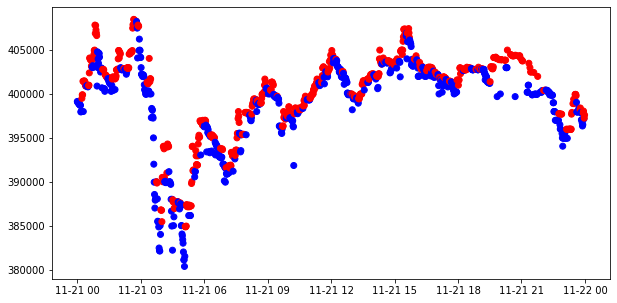

In [7]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig ==1, 'red','blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## ③ Local Min-Max 적용하기
- 최소 - 최대 구간을 이어나가며 Labeling하는 함수

In [8]:
# Q. 코드를 작성해주세요

# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time' : min_idxes, 'local_min':mins}),  pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) # ⑧

In [10]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

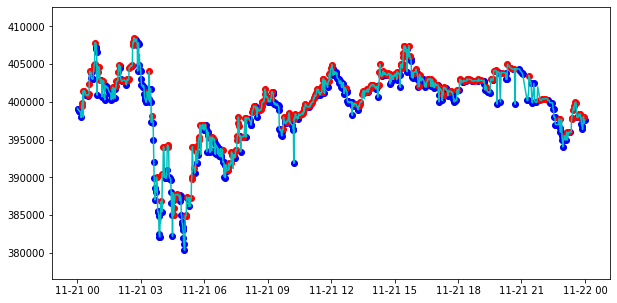

In [11]:
# Q. 코드를 작성해주세요

# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## ④ Trend Scanning 적용하기
- ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend)를 추정

In [12]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [13]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [14]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:46<00:00, 40.37it/s]


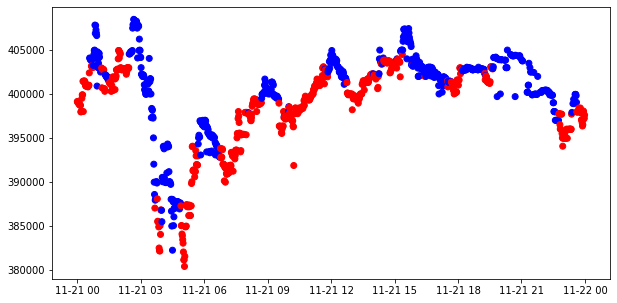

In [15]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# 2. 프로젝트 : Feature Engineering

## ① 환경구성 및 데이터 불러오기

In [16]:
!pip install ta==0.9.0
!pip install shap

In [17]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [18]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

## ② Technical Index 적용하기

In [19]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [20]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [21]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]  # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [22]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight = 'balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## ③ Feature Selection methods 적용하기

### * MDI

In [23]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.050664,0.002212
volume_fi,0.047862,0.002261
volume_mfi,0.043063,0.002407
volume_sma_em,0.033815,0.001775
volume_vpt,0.026516,0.001481
volatility_atr,0.075730,0.003173
volatility_ui,0.050472,0.002773
trend_macd_diff,0.077711,0.003583
trend_adx,0.053483,0.002786
trend_trix,0.068302,0.003522


### * MDA

In [24]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [25]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

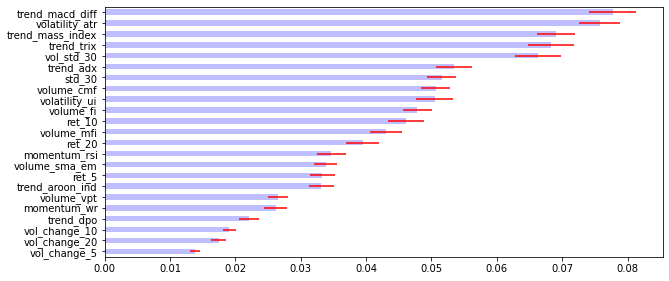

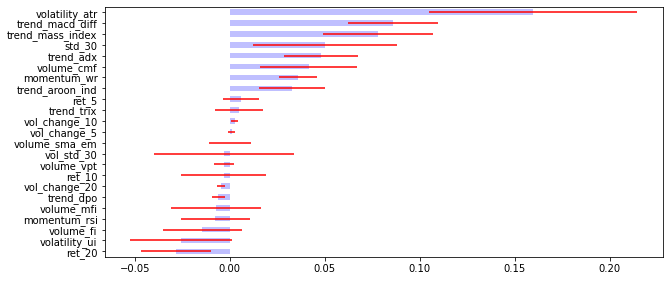

In [26]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

### * RFE CV

In [28]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV 사용
rfe_fitted = rfe_cv.fit(X_sc, y) # fit 사용

### * SFS

In [29]:
# SFS, Sequential Feature Selection
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

### * SHAP

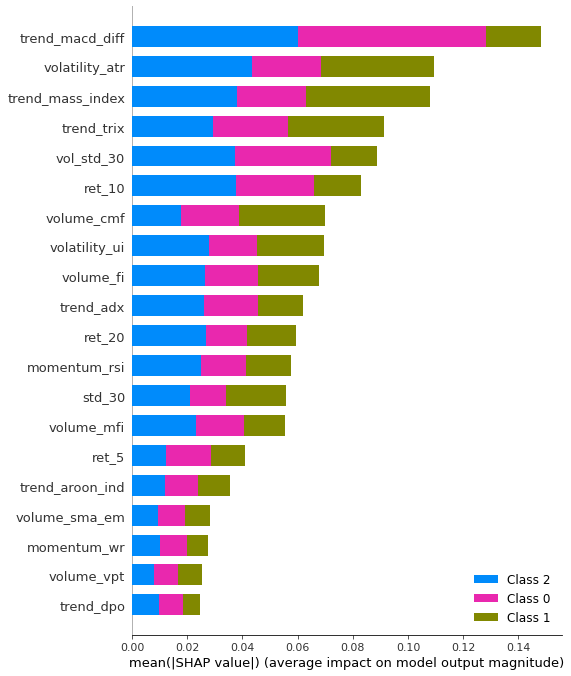

In [30]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# 3. 프로젝트 : Model Traning

## ① 환경구성 및 데이터 불러오기

In [31]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [33]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

## ② Purged K-fold for Cross-Validation적용하기

In [69]:
# Q. 코드를 작성해주세요

n_cv = 5 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

* n_cv는 K-Fold 교차 검증에서 Fold(폴드)의 수를 나타냅니다. K-Fold 교차 검증은 데이터를 K개의 서브셋(폴드)으로 나누고, 각 반복에서 K-1개의 폴드를 훈련 데이터로 사용하고 나머지 1개의 폴드를 테스트 데이터로 사용하여 모델을 평가하는 방법입니다. n_cv는 이때 사용할 폴드의 수를 지정합니다.

* n_cv의 값을 선택하는 기준

    - 데이터의 크기: 데이터가 크면 더 많은 폴드를 사용할 수 있습니다. 일반적으로 작은 데이터셋에서는 5 또는 10을 사용하고, 큰 데이터셋에서는 10 이상의 값을 사용할 수 있습니다.
    - 모델의 안정성과 성능: 모델의 안정성이 더 중요하다면 더 많은 폴드를 사용하는 것이 좋습니다. 모델이 데이터의 변동성에 민감하다면 폴드 수를 늘려서 안정성을 높일 수 있습니다. 그러나 이는 계산 비용이 늘어날 수 있습니다.
    - 계산 리소스: 모델을 평가하는 데 사용할 수 있는 계산 리소스도 고려해야 합니다. 너무 많은 폴드를 사용하면 계산 시간이 길어질 수 있습니다.
    - 일반적으로 5 또는 10을 시작으로 삼고, 이후에는 데이터의 특성과 모델의 요구에 따라 조절할 수 있습니다. 따라서 n_cv가 4로 선택된 것은 해당 문제에 적합한 교차 검증을 위한 폴드의 수로 보입니다.

## ③ Model 적용하기

### 1) 파라미터 변경 (n_cv : 5, n_estimator, max_depth, min_sample)

In [70]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [10, 15, 30],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [5,10,15,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

* 파라미터의 구간을 좀 더 넓게 설정해보았다.

In [72]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [73]:
# fit
gs_rfc.fit(train_x, train_y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=PKFold(n_splits=5, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: d...me64[ns]),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [5, 10, 15, 20],
                         'base_estimator__max_features': [None, 'auto'],
                         'base_estimator__min_samples_leaf': [3, 5, 10],
                         'bootstrap_features': [False, True],
                         'max_features': [0.5, 0.7],
                         'n_estimators': [10, 15, 30]},
             verbose=1)

In [74]:
# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=15,
                                                        min_samples_leaf=3),
                  bootstrap_features=True, max_features=0.5, n_estimators=15)

In [75]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [157]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average=None)
recall    = recall_score(test_y, pred_y, average=None)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision.max()}, 재현율:{recall.max()}')

================= confusion matrix ====================
[[30 25 24]
 [ 9 16 32]
 [ 0 12 43]]
정확도:0.46596858638743455, 정밀도:0.7692307692307693, 재현율:0.7818181818181819


### 2) 파라미터 변경 (n_cv : 3, n_estimator, max_depth, min_sample)

In [84]:
# Q. 코드를 작성해주세요

n_cv = 3 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

In [85]:
bc_params = {'n_estimators': [18, 20, 25],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [2, 3, 5,10],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [5,10,13],
             'bootstrap_features': [False, True]
            }

In [86]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

# fit
gs_rfc.fit(train_x, train_y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=PKFold(n_splits=3, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: d...ime64[ns]),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [2, 3, 5, 10],
                         'base_estimator__max_features': [None, 'auto'],
                         'base_estimator__min_samples_leaf': [5, 10, 13],
                         'bootstrap_features': [False, True],
                         'max_features': [0.5, 0.7],
                         'n_estimators': [18, 20, 25]},
             verbose=1)

In [87]:
# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        min_samples_leaf=5),
                  bootstrap_features=True, max_features=0.7, n_estimators=20)

In [159]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [160]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average=None)
recall    = recall_score(test_y, pred_y, average=None)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision.max()}, 재현율:{recall.max()}')

================= confusion matrix ====================
[[39 12 28]
 [10 14 33]
 [ 0  8 47]]
정확도:0.5235602094240838, 정밀도:0.7959183673469388, 재현율:0.8545454545454545


1. 데이터 라벨링 방법 4가지 및 각종 지표를 적용한 데이터셋을 활용하여 특성선택을 시도하였다.

2. PKFold의 split 개수, 데이터 비율, 데이터 개수 등의 파라미터 변경 및 모델 변경을 시도하고 기존의 결과와 비교하였다.

3. classification report에서 accuracy, precision, recall의 성능을 5% 이상 향상 시켰다.

1) 앞에서 했던 모델링의 결과
- 정확도:0.6335078534031413, 정밀도:0.422680412371134, 재현율:0.745454545454545
- auc:0.6668449197860963  

2) 모델 개선 후 모델링의 결과
- 1. 정확도:0.46596858638743455, 정밀도:0.7692307692307693, 재현율:0.7818181818181819
- 2. 정확도:0.5235602094240838, 정밀도:0.7959183673469388, 재현율:0.8545454545454545



### 회고
- time series는 생각보다 좀 어렵고 복잡한 내용이 많았습니다. 따로 공부를 하면서 내용을 차근차근 숙지해나가야 할 것 같습니다. SHAP에 대해서 datathon에서도 간략히 보았지만, 제대로 공부해야겠다는 생각을 했습니다. 금융데이터를 확인하는 매우 다양한 기술적 지표의 종류를 확인하고, 그 의미와 구현 방식에 대해 알 수 있었습니다.